In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
from collections import Counter
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
from random import sample
import math
import json
import random
import os
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})
%matplotlib ipympl

In [6]:
def determine_n(n,m,quer_info,N_q):
    
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    n = M.addVar(vtype='I', name=f"n") 
    M.addConstr(n >= 0)
    
    count = 0
    
    for info in quer_info:
        if count > N_q: break
        
        for sample in info[1]:
            if count > N_q: break
            M.addConstr(n <= sample + info[0])
            M.addConstr(n >= sample - info[0])
            count += 1
            
    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = 2**10
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        # out_x = np.zeros_like(x)
        # for i in range(len(x)):
        #     for j in range(len(x[0])):
        #         out_x[i][j] = x[i][j].Xn
        # # print([var.Xn for var in m.getVars()])
        out_lst.append(n.Xn)
        
    # print(count)
    return out_lst

def Y_j(c,dist):
    if dist == 'uniform':
        return np.random.randint(-c,c+1)
    elif dist == 'triangle':
        return round(np.random.triangular(-c, 0, c))
    return None
    
def gen_queries_determining_n(n,m,c,dist):
    
    queries = []
    
    for i in range(m+1):
        quer = []
        quer.append(c*(2**i))
        samps = []
        for j in range(len(list(itertools.combinations(range(m),i)))):
            samps.append(n + sum(Y_j(c,dist) for x in range(2**i)))
        quer.append(samps)
        queries.append(quer)

    return queries

In [15]:
gen_queries_determining_n(10,3,1,'uniform')

[[1, [9]], [2, [12, 11, 10]], [4, [9, 12, 12]], [8, [11]]]

In [13]:
n = 10
m = 7
c = 4
dist = 'triangle'
# N_q = 300

results = defaultdict()



N_trials = 100

for c in range(1,5):
    out_lst = []
    for j in range(N_trials):
        quer_info = gen_queries_determining_n(n,m,c,dist)
        lst = []
        for i in range(50):
            lst.append(len(determine_n(n,m,quer_info,i)))
        out_lst.append(lst)
    data = np.array(out_lst)
    y_vals = np.average(data, axis=0)
    results[c] = y_vals

In [9]:
cwd = os.getcwd()
cwd

'/Users/hmcarthur/differential_privacy'

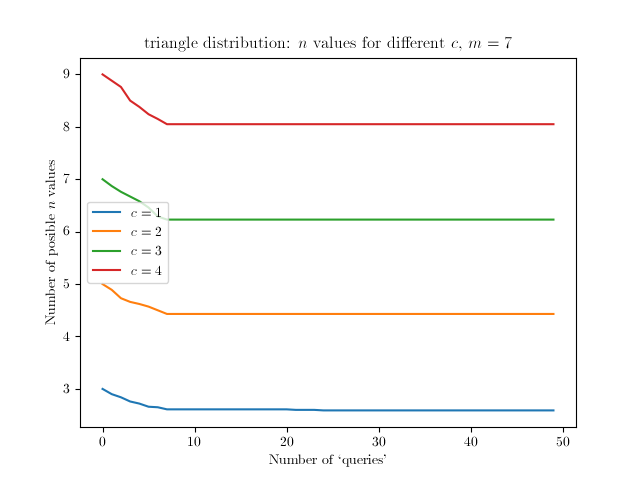

In [14]:
plt.figure()
x = [i for i in range(50)]
keys = results.keys()

for key in keys:
    y = [results[key][i] for i in x]
    plt.plot(x, y, label = f'$c = {key}$')

plt.xlabel('Number of `queries\'')
plt.ylabel(f'Number of posible $n$ values')
# plt.xscale('log')
# plt.yscale('log')
plt.title(f"{dist} distribution: $n$ values for different $c$, $m=7$")
# plt.title(f'{heading_dict[feature]} for varying $c, m=5, n=30, N_{{trials}} =30$')
# plt.title(f"$c$")
# plt.ylim([0,105])
plt.legend()
plt.savefig(f'toy_model_ILP/determining_n/figures/{dist}_m_7.pdf') 
plt.show()